<a href="https://colab.research.google.com/github/gustafbjurstam/ML-retreat-tekmek-2025/blob/main/supervised_classification_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Table of Contents
1. **Supervised Classification Methods**  
   1.1 Introduction  
   1.2 What does Supervised Classification mean?  
   1.3 Roadmap  
2. **Motivating Example: Fluid Flow Classification**  
   2.1 Problem setup  
   2.2 Mathematical models  
3. **Logistic Regression**  
   3.1 Short recap  
   3.2 Performance
4. **k-Nearest Neighbors (k-NN)**  
   4.1 Short recap  
   4.2 Distance metrics  
   4.3 Advantages and disadvantages  
5. **Support Vector Machine (SVM)**  
   5.1 Hard and Soft Margins  
   5.2 Non-linear data  
6. **Multi-Layer Perceptron (MLP)**  
7. **Classification methods comparison

---

## What does "Supervised Classification" mean?

In **supervised learning**, each training example is a pair $(\mathbf{x}_i, y_i)$ where $\mathbf{x}_i$ is a feature vector and $y_i$ is a **known label**. The goal is to learn a function $f_\theta: \mathcal{X} \rightarrow \mathcal{Y}$ that **generalizes**: it predicts accurate labels for **new, unseen** inputs drawn from the same data-generating process.

In **classification**, $y_i$ takes values in a **finite set** of categories (e.g., laminar-like / transitional / turbulent-like).

**Our setting.** Each sample is a 1D velocity profile $u(y)$ sampled on a fixed grid (a ~50-D feature vector). We construct a **continuum of regimes** by mixing laminar and turbulent baselines with a parameter $\alpha \in [0,1]$ and then discretize into three labels: laminar-like, transitional, turbulent-like. This gives an interpretable **difficulty knob**: predictions near $\alpha \approx 0.5$ are inherently harder.


---

## Roadmap

For each classification method, we'll follow a consistent structure:
1. **Intuition and how it works** — Understand or recall the basic idea behind the method, key mechanics and parameters.
2. **Fluid velocity profile application** — We will test the performance of different methods using this example.

By the end of this notebook, you'll have an intuitive and practical understanding of:
- Logistic Regression  
- k-Nearest Neighbors (k-NN)
- Support Vector Machine (SVM)
- Multi-Layer Perceptron (MLP)
- Classification methods comparison


In [20]:
#@title Setup: Import all required libraries

# Core scientific computing
import numpy as np
import matplotlib.pyplot as plt

# Interactive widgets
import ipywidgets as widgets
from ipywidgets import interact, FloatSlider, FloatLogSlider
from IPython.display import display

# Machine learning - datasets
from sklearn.datasets import make_blobs

# Machine learning - preprocessing
from sklearn.preprocessing import PolynomialFeatures

# Machine learning - pipeline
from sklearn.pipeline import make_pipeline

# Machine learning - models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# Machine learning - model selection
from sklearn.model_selection import train_test_split

# Machine learning - metrics
from sklearn.metrics import accuracy_score, confusion_matrix

# Motivating Example: Fluid Flow Classification

To make things concrete, we will classify **velocity profiles** in pipe flow.

## Problem Setup

**Physical system.** Fluid in a circular pipe. Across a diameter, the speed is highest at the center and drops to zero at the walls (no-slip).  
**Data.** We sample the velocity at 51 equally spaced points across the diameter, giving a **51-dimensional feature vector** for each observation.

**Three regimes (our labels):**
- **Laminar-like**: sharply curved, parabolic shape  
- **Transitional**: in between, neither fully parabolic nor fully flat  
- **Turbulent-like**: flatter core, fuller profile

We will generate these profiles synthetically so we can control difficulty and noise.

## Geometry and Normalization

**Radial coordinate \( y \).** Normalize the diameter so $y \in [-1, 1]$:
- $y=-1$: left wall
- $y=0$: centerline
- $y=+1$: right wall

**Velocity $v(y)$.** We also normalize by the centerline speed $u_\infty$ so curves are comparable across settings.

This makes the setup **scale-independent** (millimeter capillary or meter-scale pipe have same treatment).

## Mathematical Models

We start from two simple baseline shapes:

- **Laminar (parabolic):**  
  $$
  v_{\text{lam}}(y) = u_\infty - y^2 + \varepsilon
  $$
- **Turbulent-like (power law):**  
  $$
  v_{\text{turb}}(y) = u_\infty - C\,|y|^{7} + \varepsilon
  $$
Here $\varepsilon \sim \mathcal{N}(0,\sigma^2)$ is small measurement noise, and $C$ controls how flat the turbulent-like core is.

### Transitional regime via convex combination ($\alpha$-mixing)

To model intermediate cases, we blend the two baselines:
$$
v_\alpha(y) = (1-\alpha)\,v_{\text{lam}}(y) + \alpha\,v_{\text{turb}}(y) + \varepsilon, \quad \alpha \in [0,1].
$$

We then assign **class labels** directly from $\alpha$:
- **Laminar-like:** $\alpha < 0.25$  
- **Transitional:** $0.25 \le \alpha \le 0.75$  
- **Turbulent-like:** $\alpha > 0.75$


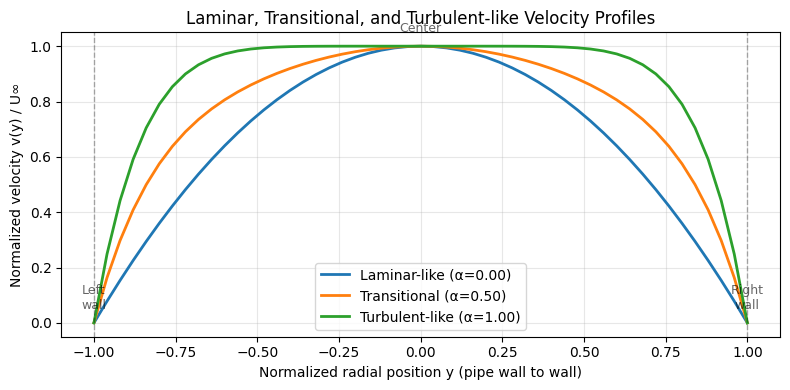

In [21]:
#@title Visualizing laminar, transitional, and turbulent velocity profiles
#MARCO

import numpy as np
import matplotlib.pyplot as plt

def generate_velocity_profile(flow_type='laminar', u_infty=1.0, C=1.0, sigma=0.01, n_points=51, seed=None):
    """
    Generate a velocity profile across a pipe diameter.

    Parameters:
    - flow_type (str): 'laminar' or 'turbulent'
    - u_infty (float): centerline velocity (maximum speed)
    - C (float): turbulent profile shape constant
    - sigma (float): measurement noise level
    - n_points (int): measurement points across diameter
    - seed (int or None): random seed for reproducibility

    Returns:
    - y (np.ndarray): normalized radial positions [-1, 1]
    - v (np.ndarray): velocity at each position
    """
    if seed is not None:
        np.random.seed(seed)

    # Normalized positions: -1 (left wall) to +1 (right wall)
    y = np.linspace(-1, 1, n_points)

    # Measurement noise
    noise = np.random.normal(loc=0.0, scale=sigma, size=n_points)

    if flow_type == 'laminar':
        v = u_infty - y**2 + noise
    elif flow_type == 'turbulent':
        v = u_infty - C * (np.abs(y))**7 + noise
    else:
        raise ValueError("flow_type must be either 'laminar' or 'turbulent'")

    return y, v

def generate_hybrid_velocity_profile(alpha, u_infty=1.0, C=1.0, sigma=0.0, n_points=51, seed=None):
    """
    Hybrid profile via convex combination:
        v_alpha = (1 - alpha)*v_laminar + alpha*v_turbulent + noise
    """
    if not (0.0 <= alpha <= 1.0):
        raise ValueError("alpha must be in [0, 1].")
    if seed is not None:
        np.random.seed(seed)

    # Get noise-free baselines for a clean mix
    y, v_lam = generate_velocity_profile('laminar', u_infty=u_infty, C=C, sigma=0.0, n_points=n_points)
    _, v_tur = generate_velocity_profile('turbulent', u_infty=u_infty, C=C, sigma=0.0, n_points=n_points)

    v = (1 - alpha) * v_lam + alpha * v_tur
    # Single noise injection post-mix (kept 0.0 here for clarity in the demo)
    v = v + np.random.normal(0.0, sigma, size=n_points)
    return y, v

# --- Plot the three illustrative cases (noise-free) ---
alphas = [0.0, 0.5, 1.0]  # laminar-like, transitional, turbulent-like
labels = ["Laminar-like (α=0.00)", "Transitional (α=0.50)", "Turbulent-like (α=1.00)"]

plt.figure(figsize=(8, 4))
for a, lbl in zip(alphas, labels):
    y, v = generate_hybrid_velocity_profile(alpha=a, sigma=0.0, n_points=51, C=1.0, u_infty=1.0, seed=42)
    plt.plot(y, v, linewidth=2, label=lbl)

plt.xlabel("Normalized radial position y (pipe wall to wall)")
plt.ylabel("Normalized velocity v(y) / U∞")
plt.title("Laminar, Transitional, and Turbulent-like Velocity Profiles")
plt.axvline(x=-1, color='k', linestyle='--', alpha=0.3, linewidth=1)
plt.axvline(x=1, color='k', linestyle='--', alpha=0.3, linewidth=1)
plt.text(-1, 0.05, 'Left\nwall', ha='center', fontsize=9, alpha=0.6)
plt.text(1, 0.05, 'Right\nwall', ha='center', fontsize=9, alpha=0.6)
plt.text(0, 1.05, 'Center', ha='center', fontsize=9, alpha=0.6)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Logistic Regression
We have treated logistic regression already, so we just recall the main ideas here.

## Quick refresher
Logistic regression is a linear classifier: it learns a weighted sum of the input features and passes it through a squashing function to produce probabilities. In the binary case, the sigmoid turns the score into
$P(y=1|x)$; the decision boundary is a hyperplane (linear in the features). We fit the weights by maximizing the likelihood (equivalently, minimizing cross-entropy), typically with a bit of regularization to avoid overfitting.

**Multiclass classification**. We use the multinomial/softmax extension: the model learns one linear score per class, converts all scores into a probability distribution over {laminar-like, transitional, turbulent-like} via softmax (they sum to 1), and predicts the class with the highest probability. Intuitively, this is just the binary idea applied jointly to all classes rather than training separate one-vs-rest models.


## Fluid velocity profile application

We will now test the performance of the logistic regression method on the velocity profile dataset. We will first generate 1500 samples (adding noise).

A test dataset (10%) is kept aside to fairly check on the model performance.

In [4]:
# @title Logistic regression performance on fluid velocity profile dataset.
# MARCO
# --- Multiclass Logistic Regression on 3-class velocity profiles (no interactive knob) ---

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
)

# Assumes you already defined generate_velocity_profile(flow_type=..., ...)
# We add a tiny helper to create hybrid profiles with alpha in [0,1].

def generate_hybrid_profile(alpha, n_points=51, sigma=0.03, C=1.0, u_infty=1.0, seed=None):
    """Hybrid profile: v_alpha = (1-alpha)*v_lam + alpha*v_turb + noise."""
    if seed is not None:
        rng = np.random.default_rng(seed)
    else:
        rng = np.random.default_rng()
    y, v_lam = generate_velocity_profile('laminar', u_infty=u_infty, C=C, sigma=0.0, n_points=n_points)
    _, v_turb = generate_velocity_profile('turbulent', u_infty=u_infty, C=C, sigma=0.0, n_points=n_points)
    v = (1 - alpha) * v_lam + alpha * v_turb
    v = v + rng.normal(0.0, sigma, size=n_points)  # single noise injection
    return y, v

def label_from_alpha(alpha):
    """3-class labeling based on alpha."""
    if alpha < 0.25:
        return 0  # laminar-like
    elif alpha > 0.75:
        return 2  # turbulent-like
    else:
        return 1  # transitional

# --- Generate dataset ---
n_samples = 1500
n_points = 51
sigma = 0.05
C = 1.0
u_infty = 1.0
rng = np.random.default_rng(123)

alphas = rng.uniform(0.0, 1.0, size=n_samples)
X = np.empty((n_samples, n_points))
y = np.empty(n_samples, dtype=int)

for i, a in enumerate(alphas):
    _, v = generate_hybrid_profile(a, n_points=n_points, sigma=sigma, C=C, u_infty=u_infty, seed=rng.integers(1e9))
    X[i] = v
    y[i] = label_from_alpha(a)

# --- Stratified split: use 10% as test ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.10, stratify=y, random_state=42
)

# --- Multinomial Logistic Regression with scaling ---
logreg = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        multi_class="multinomial",
        solver="lbfgs",
        max_iter=2000,
        random_state=42
    )
)

logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

# --- Metrics (simple and relevant) ---
acc = accuracy_score(y_test, y_pred)
prec_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
    y_test, y_pred, average="macro", zero_division=0
)

print(f"Accuracy:       {acc:.3f}")
print(f"Precision (µ):  {prec_macro:.3f}")
print(f"Recall (µ):     {recall_macro:.3f}")
print(f"F1 (µ):         {f1_macro:.3f}\n")

target_names = ["Laminar-like (0)", "Transitional (1)", "Turbulent-like (2)"]
print(classification_report(y_test, y_pred, target_names=target_names, digits=3))


Accuracy:       0.927
Precision (µ):  0.925
Recall (µ):     0.928
F1 (µ):         0.926

                    precision    recall  f1-score   support

  Laminar-like (0)      0.900     0.973     0.935        37
  Transitional (1)      0.934     0.922     0.928        77
Turbulent-like (2)      0.941     0.889     0.914        36

          accuracy                          0.927       150
         macro avg      0.925     0.928     0.926       150
      weighted avg      0.927     0.927     0.927       150



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Generate a new velocity profile by changing $\alpha$ (pure laminar=0, pure turbulent=1) and $\sigma$ for the noise the noise level

In [18]:
Alpha = 0.77 # 0: pure laminar; 1: pure turbulent
Sigma = 0.05 # originally 0.05

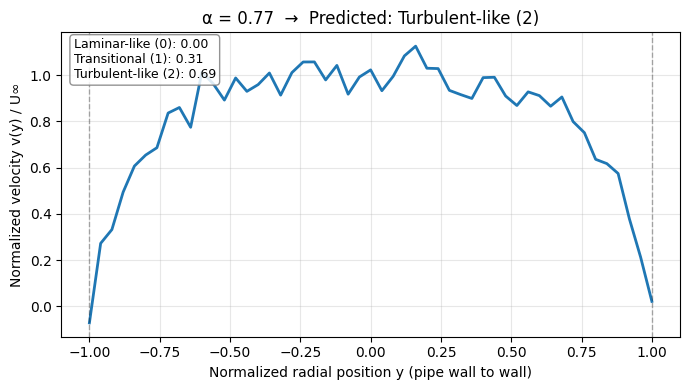

In [19]:
#@title Run to evaluate the new velocity profile
# MARCO
# --- Predict a new profile by choosing alpha and visualize it ---

import numpy as np
import matplotlib.pyplot as plt

# Class names (consistent with earlier labeling)
CLASS_NAMES = ["Laminar-like (0)", "Transitional (1)", "Turbulent-like (2)"]

def classify_and_plot(alpha=0.50, sigma=0.05, C=1.0, u_infty=1.0, n_points=51, seed=12345):
    """
    Generate a single hybrid profile for given alpha, classify with the trained model,
    and plot the velocity profile.
    """
    # Generate profile (single noise injection; fixed seed for reproducibility)
    y, v = generate_hybrid_profile(alpha, n_points=n_points, sigma=sigma,
                                   C=C, u_infty=u_infty, seed=seed)

    # Predict with the trained pipeline
    pred_class = int(logreg.predict(v.reshape(1, -1))[0])
    proba = logreg.predict_proba(v.reshape(1, -1))[0]

    # Plot
    plt.figure(figsize=(7, 4))
    plt.plot(y, v, linewidth=2)
    plt.xlabel("Normalized radial position y (pipe wall to wall)")
    plt.ylabel("Normalized velocity v(y) / U∞")
    plt.title(f"α = {alpha:.2f}  →  Predicted: {CLASS_NAMES[pred_class]}")
    plt.axvline(x=-1, color='k', linestyle='--', alpha=0.3, linewidth=1)
    plt.axvline(x=1, color='k', linestyle='--', alpha=0.3, linewidth=1)
    plt.grid(True, alpha=0.3)

    # Add probabilities as a small textbox on the plot
    prob_text = "\n".join(f"{name}: {p:.2f}" for name, p in zip(CLASS_NAMES, proba))
    plt.text(0.02, 0.98, prob_text, transform=plt.gca().transAxes,
             va='top', ha='left', fontsize=9,
             bbox=dict(boxstyle='round', fc='white', ec='gray', alpha=0.85))

    plt.tight_layout()
    plt.show()

# Example usage: change alpha in this call to test different profiles
classify_and_plot(alpha=Alpha, sigma=Sigma)


# k-Nearest Neighbors (k-NN)

## Intuition and how it works

k-Nearest Neighbors (k-NN) has a very intuitive principle of work. In fact, it's name already explains it. Unlike logistic regression, k-NN can be used for multi-class classification "out of the box". Here is the way k-NN works:

1. Pick a data point you want to classify.
2. Find k nearest neighbors. A neighbor is one of k data points closest to the point we want to classify.
3. Assign the class to the point that corresponds to the majority class within the k neighbors.

And that is all, nice and simple! The only parameters we need to decide on are k and the way that the distance between points is calculated. If we choose too low k then the results can be noisy since few neighbors decide on the classification. On the other hand, picking too high of k can lead to outright rejection of classes that do not have many points in the data set. Play around with the demo below and try to recreate those two scenarios.



# k-Nearest Neighbors (k-NN)

## Intuition and how it works

k-Nearest Neighbors (k-NN) has a very intuitive principle of work. In fact, its name already explains it. Unlike logistic regression, k-NN can be used for multi-class classification "out of the box". Here is the way k-NN works:

1. Pick a data point you want to classify.
2. Find the k nearest neighbors.
3. Assign the class to the point that corresponds to the majority class within the k neighbors.

And that is all — nice and simple! The only parameters we need to decide on are **k** and the way that the **distance between points is calculated**.

## Distance metrics

Different datasets and problem domains can benefit from different distance metrics. Here are some common options:

- **Euclidean distance** (default): Good for continuous, geometrically well-behaved data.
- **Manhattan distance**: More robust when the data contains outliers or if dimensions are not directly comparable.
- **Minkowski distance**: A generalization of both Euclidean and Manhattan (you can tune its power parameter).
- **Cosine similarity**: Often used for text or high-dimensional sparse data, where direction matters more than magnitude.

Choosing the right distance metric helps k-NN reflect the true "closeness" between data points in a meaningful way for your specific problem.

## Advantages and disadvantages

**Advantages:**

- Very simple and intuitive.
- Naturally handles multi-class classification.
- No training phase — the model just stores the data.

**Disadvantages:**

- Computationally expensive at prediction time (especially for large datasets).
- Performance can degrade in high-dimensional spaces ("curse of dimensionality").
- Sensitive to irrelevant or redundant features and scaling of data.

Play around with the demo below and try to recreate different behaviors by changing **k** and experimenting with how points are distributed. Try small values of k to see overfitting in action, or high values to observe how the model smooths over finer details.


In [7]:
#@title Interactive k-NN demo
%matplotlib inline


# === Generate dataset ===
centers = [(-2, -2), (2, 0), (-1, 4), (3, 7)]
cluster_std = [1.0, 1.5, 0.5, 1.0]
X, y_labels = make_blobs(n_samples=[100, 200, 5, 100], centers=centers, cluster_std=cluster_std, random_state=42)

# === Fit once globally ===
knn_global = KNeighborsClassifier()
knn_global.fit(X, y_labels)

# === Define plotting function ===
def plot_knn_decision_boundary(x=0.0, y=0.0, k=5, show_lines=True):
    # Convert slider inputs to native float (in case they are numpy scalars)
    x = float(x)
    y = float(y)

    # Refit classifier with selected k
    knn_global.set_params(n_neighbors=k)
    knn_global.fit(X, y_labels)

    # Mesh grid for decision boundary
    h = 0.1
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = knn_global.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Query point and neighbors
    query_point = np.array([[x, y]])
    query_class = knn_global.predict(query_point)[0]
    print(f"color is: {query_class}")
    distances, indices = knn_global.kneighbors(query_point)
    neighbor_pts = X[indices[0]]

    # Define class colors
    color_map = {
    0: 'blue',
    1: 'red',
    2: 'pink',
    3: 'cyan',
    }

    # Plotting
    fig, ax = plt.subplots(figsize=(8, 7))
    ax.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.tab10)
    ax.scatter(X[:, 0], X[:, 1], c=y_labels, cmap=plt.cm.tab10, edgecolor='k', s=50)

    if show_lines:
        for pt in neighbor_pts:
            ax.plot([x, pt[0]], [y, pt[1]], 'k--', linewidth=1)

    ax.scatter(neighbor_pts[:, 0], neighbor_pts[:, 1],
               facecolors='none', edgecolors='black', s=150, linewidths=2, label='Neighbors')

    ax.scatter(x, y, c=color_map[query_class], edgecolor='k', s=200, marker='o', label='Query Point')

    ax.set_title(f"Interactive k-NN Classification (k={k})", fontsize=14)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()


# === Sliders ===
x_slider = widgets.FloatSlider(value=2.0, min=-4.0, max=6.0, step=0.1, description='x:')
y_slider = widgets.FloatSlider(value=6.0, min=-4.0, max=9.0, step=0.1, description='y:')
k_slider = widgets.IntSlider(value=5, min=1, max=20, step=1, description='k:')
lines_toggle = widgets.Checkbox(value=True, description='Show lines to neighbors')

interactive_plot = widgets.interactive_output(
    plot_knn_decision_boundary,
    {'x': x_slider, 'y': y_slider, 'k': k_slider, 'show_lines': lines_toggle}
)

ui = widgets.VBox([x_slider, y_slider, k_slider, lines_toggle])
display(ui, interactive_plot)


Output()

Accuracy: 1.00


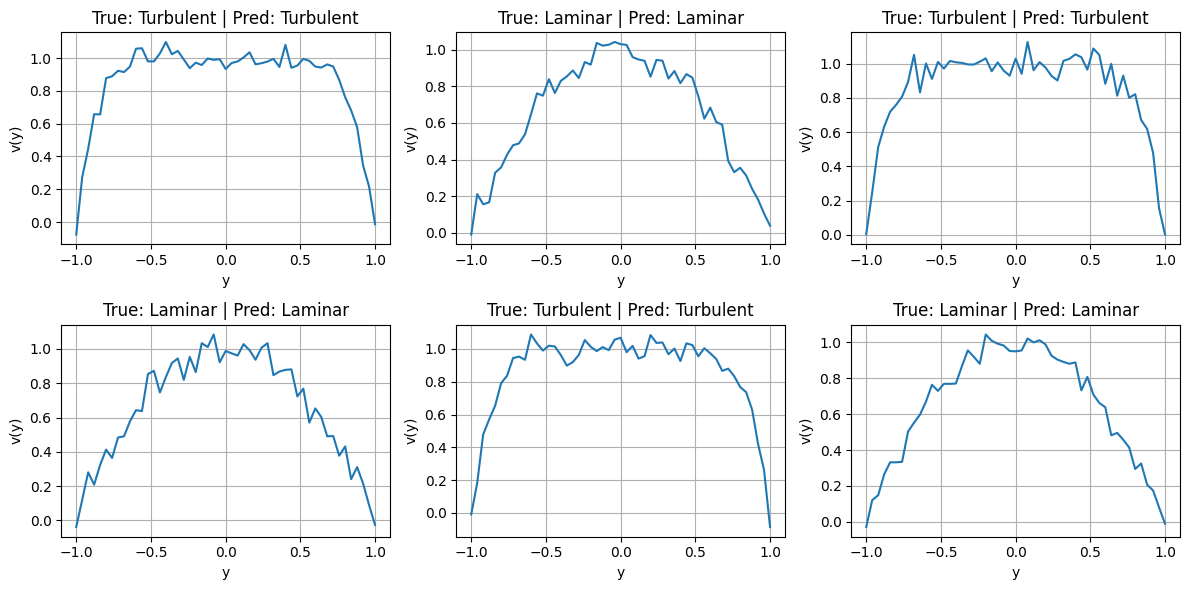

In [8]:
#@title Flow velocity profile application

# --- Generate labeled dataset ---
n_samples_per_class = 200
n_points = 51
sigma = 0.05  # noise level

X = []
y = []

for i in range(n_samples_per_class):
    _, v_laminar = generate_velocity_profile('laminar', sigma=sigma)
    _, v_turbulent = generate_velocity_profile('turbulent', sigma=sigma)
    X.append(v_laminar)
    y.append(0)
    X.append(v_turbulent)
    y.append(1)

X = np.array(X)
y = np.array(y)

# --- Split into train/test sets ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Fit k-NN model ---
k = 5
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)

# --- Evaluate the model ---
y_pred = knn.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.2f}")

# --- Optional: show confusion matrix ---
# print("Confusion matrix:")
# print(confusion_matrix(y_test, y_pred))

# --- Visualize a few examples ---
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
y_vals = np.linspace(-1, 1, n_points)
for i, ax in enumerate(axes.ravel()):
    idx = i
    ax.plot(y_vals, X_test[idx], label="Velocity profile")
    pred = knn.predict(X_test[idx].reshape(1, -1))[0]
    true = y_test[idx]
    ax.set_title(f"True: {'Laminar' if true == 0 else 'Turbulent'} | Pred: {'Laminar' if pred == 0 else 'Turbulent'}")
    ax.set_xlabel("y")
    ax.set_ylabel("v(y)")
    ax.grid(True)

plt.tight_layout()
plt.show()


Once again, k-NN manages to classify the flows just fine.

# Support Vector Machine (SVM)

Another supervised machine learning classification method is the Support Vector Machine (SVM). The main idea behind it is to separate two classes using a hyperplane. Examples of hyperplanes are:

- 1D: point $h_{\theta}(x_1) = \theta_0 + \theta_1 x_1$
- 2D: line $h_{\theta}(x_1, x_2) = \theta_0 + \theta_1 x_1 + \theta_2 x_2$
- 3D: plane $h_{\theta}(x_1, x_2, x_3) = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + \theta_3 x_3$
- ... and so on

The main advantage of SVM is that the optimization problem it poses can be solved using a method called **quadratic programming**, which is computationally efficient. Contrast this with iterative methods such as gradient descent, which require multiple updates to converge to a solution. Because of this, SVM is very efficient for classifying **linearly separable** data.

Even though this seems like a limitation, we will later show how this approach can still be applied to data that is not linearly separable, through kernel methods. However, we will not cover the mathematical details of SVMs, as that is beyond the scope of this workshop.

---

Below is an example of two clusters that need to be separated with a line. What makes one line better than another?

In [9]:
#@title Figure 1
from IPython.display import display, Image, SVG, Video
display(SVG(filename='/content/decision-boundaries.svg'))

FileNotFoundError: [Errno 2] No such file or directory: '/content/decision-boundaries.svg'

Typically, the line on the left in Figure 1 appears to divide the clusters in the most natural way. This is also how SVM attempts to separate classes: by finding the hyperplane that maximizes the **margin** between the two classes (see Figure 2).

SVM’s objective is to find a decision boundary that:

- maximizes the margin between the nearest points of the two classes,
- and still correctly classifies the training examples.

The points that lie closest to the hyperplane and define the margin are called **support vectors** (see Figure 2). They are critical because the margin is "pushed" up against them from both sides.

In [10]:
#@title Figure 2
display(SVG(filename='/content/terminology.svg'))

FileNotFoundError: [Errno 2] No such file or directory: '/content/terminology.svg'

The simple demo below presents the core idea behind SVM. Try to manually find a line that separates the classes while maximizing the margin.

In [11]:
#@title SVM margin demo

# --- Generate two clusters ---
np.random.seed(1)
n_points = 10
cluster_1 = np.random.randn(n_points, 2) + np.array([-2, 4])
cluster_2 = np.random.randn(n_points, 2) + np.array([2, -4])
X = np.vstack((cluster_1, cluster_2))
y = np.array([1]*n_points + [-1]*n_points)

def svm_margin_plot(slope):
    w = -np.array([slope, -1])  # Normal vector to decision boundary
    w = w / np.linalg.norm(w)  # Normalize

    # Project points onto normal vector
    projections = X @ w
    margin_pos = projections[y == 1].min()
    margin_neg = projections[y == -1].max()
    margin = 0.5 * (margin_pos - margin_neg)
    decision_offset = 0.5 * (margin_pos + margin_neg)

    def plot_margin_line(ax, offset, style='k--', label=None):
        midpoint = offset * w
        direction = np.array([-w[1], w[0]])  # Perpendicular direction
        line_points = np.array([midpoint + t * direction for t in [-10, 10]])
        ax.plot(line_points[:, 0], line_points[:, 1], style, label=label)

    # Plotting
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(cluster_1[:, 0], cluster_1[:, 1], c='red', label='Class +1')
    ax.scatter(cluster_2[:, 0], cluster_2[:, 1], c='blue', label='Class -1')

    plot_margin_line(ax, decision_offset, style='k-', label='Decision boundary')
    plot_margin_line(ax, margin_pos, style='k--', label='Margin boundaries')
    plot_margin_line(ax, margin_neg, style='k--')

    # Highlight support vectors
    sv_pos = X[y == 1][np.argmin(projections[y == 1])]
    sv_neg = X[y == -1][np.argmax(projections[y == -1])]
    ax.scatter(*sv_pos, s=150, facecolors='none', edgecolors='red', linewidths=2, label='Support vectors')
    ax.scatter(*sv_neg, s=150, facecolors='none', edgecolors='blue', linewidths=2)

    ax.set_xlim(-10, 10)
    ax.set_ylim(-10, 15)
    ax.set_aspect('equal', adjustable='box')  # Changed this line
    ax.set_title(f"SVM Margin and Decision Boundary (slope = {slope:.2f})")
    ax.set_xlabel("x₁")
    ax.set_ylabel("x₂")
    ax.grid(True)
    ax.legend()
    plt.tight_layout()
    plt.show()

# Create interactive slider
interact(svm_margin_plot, slope=FloatSlider(value=-0.5, min=-1, max=20, step=0.1));

interactive(children=(FloatSlider(value=-0.5, description='slope', max=20.0, min=-1.0), Output()), _dom_classe…

### Hard and Soft Margins

So far, we have looked at the case where two clusters can be perfectly separated by a line. However, in many real-world datasets, misclassifications are inevitable, and a perfect separation is not possible. In such cases, the standard SVM cannot find a valid decision boundary.

What we need is some flexibility in the margin — a way to tolerate a small number of misclassified points when determining the separating hyperplane. This approach is known as the **soft margin**, as opposed to the **hard margin**, which assumes that the data is linearly separable with no exceptions.

The **soft margin** SVM introduces a mechanism to allow certain violations of the margin — that is, to allow some points to fall on the wrong side of the boundary or within the margin. This makes it more robust and better suited for real-world data.

The trade-off between maximizing the margin and minimizing classification errors is controlled by the parameter $C$. This parameter determines how much **penalty** is assigned to misclassified points:

- A **large $C$** forces the model to classify all training examples correctly (hard margin behavior), possibly at the cost of a smaller margin.
- A **small $C$** allows for more margin violations (soft margin), leading to a wider margin and potentially better generalization.

Soft-margin SVM is the **default** behavior in most machine learning libraries and toolboxes.

Below is a plot that shows the effects of different $C$ values. A hard margin can be approximated by using a very large $C$.


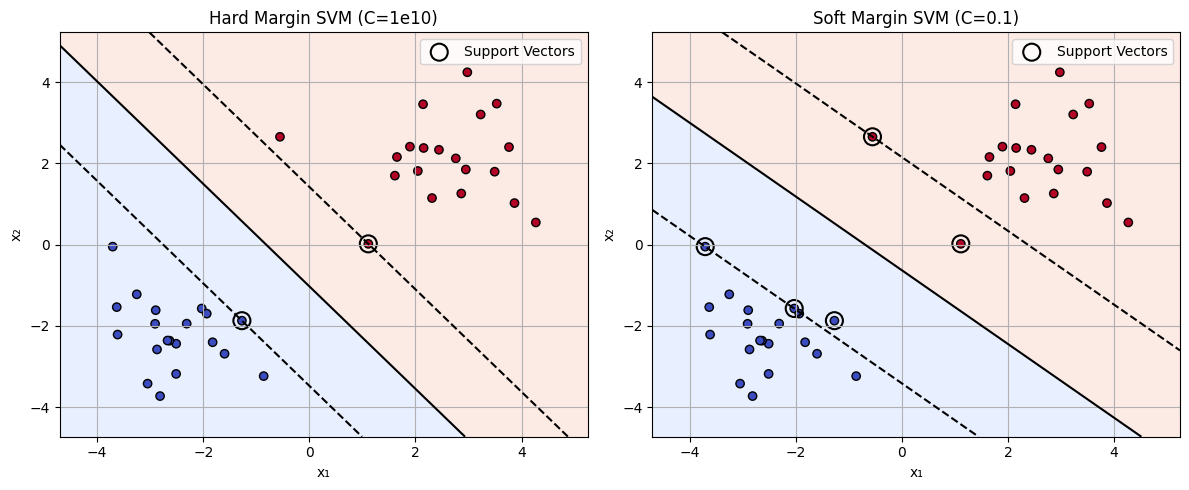

In [12]:
#@title Hard vs soft margin plot
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC

# --- Generate linearly separable data ---
np.random.seed(0)
n_samples = 20
cluster_1 = np.random.randn(n_samples, 2) + np.array([2, 2])
cluster_2 = np.random.randn(n_samples, 2) + np.array([-2, -2])
X = np.vstack((cluster_1, cluster_2))
y = np.array([1]*n_samples + [-1]*n_samples)

# --- Fit hard margin and soft margin SVM ---
svm_hard = SVC(kernel='linear', C=1e10)
svm_soft = SVC(kernel='linear', C=0.1)
svm_hard.fit(X, y)
svm_soft.fit(X, y)

# --- Create mesh for decision boundary visualization ---
h = 0.05
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
grid = np.c_[xx.ravel(), yy.ravel()]

Z_hard = svm_hard.decision_function(grid).reshape(xx.shape)
Z_soft = svm_soft.decision_function(grid).reshape(xx.shape)

# --- Plotting ---
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

titles = ['Hard Margin SVM (C=1e10)', 'Soft Margin SVM (C=0.1)']
svms = [svm_hard, svm_soft]
Zs = [Z_hard, Z_soft]

for ax, title, svm, Z in zip(axs, titles, svms, Zs):
    ax.contourf(xx, yy, Z > 0, alpha=0.2, cmap=plt.cm.coolwarm)
    ax.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], linestyles=['--', '-', '--'])

    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')
    ax.scatter(svm.support_vectors_[:, 0],
               svm.support_vectors_[:, 1],
               s=150, facecolors='none', edgecolors='k', linewidths=1.5, label='Support Vectors')

    ax.set_title(title)
    ax.set_xlabel("x₁")
    ax.set_ylabel("x₂")
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()


Now, what happens if data is not fully separable due to noisy data and outliers? That is where the hard margin version of SVM does not have any solution. The soft margin SVM however can handle such data. However, it is left up to the user to decide on an appropriate value of $C$ which will result in a decision boundary that can be generalized to the 'real' data distribution.

In [13]:
#@title Non-linearly separable data with soft margin SVM demo

# --- Generate non-linearly separable data ---
np.random.seed(1)
n_samples = 20
cluster_1 = 1.5 * np.random.randn(n_samples, 2) + np.array([1, 1])
cluster_2 = np.random.randn(n_samples, 2) + np.array([-1, -1])
X = np.vstack((cluster_1, cluster_2))
y = np.array([1] * n_samples + [-1] * n_samples)

# --- Create mesh grid for decision boundaries ---
h = 0.05
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
grid = np.c_[xx.ravel(), yy.ravel()]

def plot_svm(C):
    clf = SVC(kernel='linear', C=C)
    clf.fit(X, y)
    Z = clf.decision_function(grid).reshape(xx.shape)

    plt.figure(figsize=(6, 5))
    plt.contourf(xx, yy, Z > 0, alpha=0.2, cmap=plt.cm.coolwarm)
    plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], linestyles=['--', '-', '--'])

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')
    plt.scatter(clf.support_vectors_[:, 0],
                clf.support_vectors_[:, 1],
                s=150, facecolors='none', edgecolors='k', linewidths=1.5, label='Support Vectors')

    plt.title(f"Soft Margin SVM (C={C:.3f})")
    plt.xlabel("x₁")
    plt.ylabel("x₂")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Create interactive slider (log scale for better exploration)
interact(plot_svm, C=FloatLogSlider(value=1.0, base=10, min=-2, max=3, step=0.1, description='C'))


interactive(children=(FloatLogSlider(value=1.0, description='C', max=3.0, min=-2.0), Output()), _dom_classes=(…

<function __main__.plot_svm(C)>

### Non-linear data

At this point, it might seem like we’ve put a lot of effort into a method that can only separate data with a straight line. Fortunately, SVM has a powerful technique to handle more complex scenarios. When the raw data is not linearly separable, SVM can map it into a higher-dimensional space where a hyperplane *can* separate the clusters.

This idea is often called the "kernel trick" and is one of the key strengths of SVM. The figure below illustrates how mapping to a higher-dimensional space can make separation possible even when it looks impossible in the original feature space. The original data set $(x_1, x_2)$ is mapped into 3D space $(x_1, x_2) \mapsto (z_1, z_2, z_3) := (x_1, x_2, x_1^2 + x_2^2)$.



In [14]:
#@title Figure 3
display(Image(filename='/content/higher-space-mapping.png'))

FileNotFoundError: [Errno 2] No such file or directory: '/content/higher-space-mapping.png'

From *Data-Driven Science and Engineering: Machine Learning, Dynamical Systems, and Control*; S. L. Brunton, J. N. Kutz, p.236

SVM Accuracy: 1.00


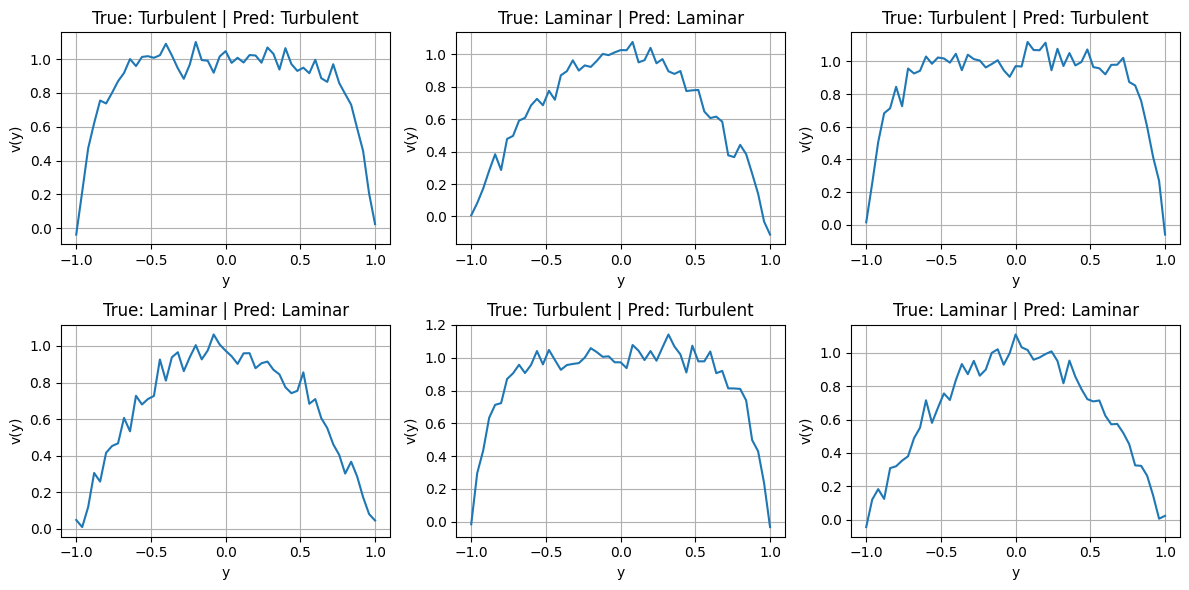

In [15]:
#@title Flow velocity profile classification using SVM

# --- Generate labeled dataset ---
n_samples_per_class = 200
n_points = 51
sigma = 0.05  # same noise level

X = []
y = []

for _ in range(n_samples_per_class):
    _, v_laminar = generate_velocity_profile('laminar', sigma=sigma)
    _, v_turbulent = generate_velocity_profile('turbulent', sigma=sigma)
    X.append(v_laminar)
    y.append(0)
    X.append(v_turbulent)
    y.append(1)

X = np.array(X)
y = np.array(y)

# --- Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Fit SVM classifier ---
svm_clf = SVC(kernel='linear')  # or try 'rbf' for more flexibility
svm_clf.fit(X_train, y_train)

# --- Evaluate ---
y_pred = svm_clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"SVM Accuracy: {acc:.2f}")

# print("Confusion matrix:")
# print(confusion_matrix(y_test, y_pred))

# --- Visualize a few test samples ---
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
y_vals = np.linspace(-1, 1, n_points)

for i, ax in enumerate(axes.ravel()):
    idx = i
    ax.plot(y_vals, X_test[idx], label="Velocity profile")
    pred = svm_clf.predict(X_test[idx].reshape(1, -1))[0]
    true = y_test[idx]
    ax.set_title(f"True: {'Laminar' if true == 0 else 'Turbulent'} | Pred: {'Laminar' if pred == 0 else 'Turbulent'}")
    ax.set_xlabel("y")
    ax.set_ylabel("v(y)")
    ax.grid(True)

plt.tight_layout()
plt.show()


SVM reaches 100% accuracy on the laminar vs turbulent flow classification.

# Multi-Layer Perceptron (MLP)

**Multi-Layer Perceptron (MLP)** is by far the most versatile and complex technique covered in this session. What makes MLPs so useful is the fact that they consist of many interconnected nodes (neurons), which can be organized into multiple layers — an input layer, one or more hidden layers, and an output layer. Thanks to this layered structure, MLPs can be used for a wide range of problems **including regression**, **classification**, and even more advanced tasks like **time series prediction** or **image recognition**. Most importantly, MLPs allow for learning complex non-linear functions that traditional linear models cannot capture.

However, this flexibility comes with the challenge of selecting appropriate hyperparameters, which significantly affect performance:

- **Hidden Layer Size**: The number of neurons in each hidden layer (e.g. one layer `(100,)` vs. two layers `(100, 50)`). More neurons and more layers increase model capacity but also the risk of overfitting.

- **Number of Hidden Layers**: Increasing the depth (i.e. number of layers) enables learning more complex patterns, but also makes training harder.

- **Activation Function**: Determines the non-linearity at each neuron. Common choices include 'relu', 'tanh', and 'logistic'.

- **Learning Rate**: Controls how fast the model updates its weights during training. Too high can make learning unstable; too low can slow convergence.

- **Regularization (alpha)**: Prevents overfitting by penalizing large weights. A higher alpha applies stronger regularization.

- **Max Iterations**: The maximum number of training epochs. If the model doesn't converge, you might need to increase this.

- **Solver**: The optimization algorithm used (e.g., `'adam'`, `'sgd'`, `'lbfgs'`). `'adam'` is often a good default for most tasks.

Choosing good hyperparameters often requires experimentation and sometimes cross-validation. In practice, using tools like `GridSearchCV` or `RandomizedSearchCV` can help automate this process. We will cover MLPs in more detail in the upcoming sessions.

In the following example, we see how an MLP can classify a highly non-linear dataset — something that simpler models cannot do.

Test Accuracy: 1.00


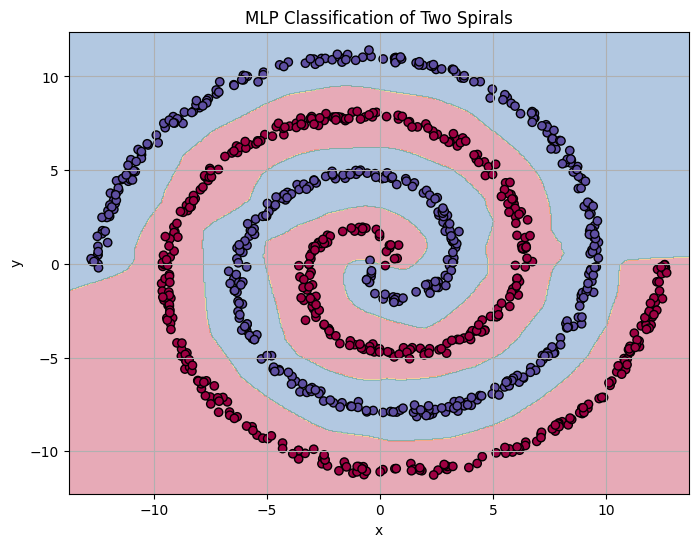

In [16]:
#@title MLP example

# --- Generate two spiral dataset ---
def generate_spiral(n_points, noise=0.2):
    theta = np.sqrt(np.random.rand(n_points)) * 4 * np.pi  # Angle
    r = theta
    x1 = r * np.cos(theta) + np.random.randn(n_points) * noise
    y1 = r * np.sin(theta) + np.random.randn(n_points) * noise

    x2 = -r * np.cos(theta) + np.random.randn(n_points) * noise
    y2 = -r * np.sin(theta) + np.random.randn(n_points) * noise

    X = np.vstack((np.column_stack((x1, y1)), np.column_stack((x2, y2))))
    y = np.array([0]*n_points + [1]*n_points)
    return X, y

X, y = generate_spiral(500, noise=0.15)

# --- Split data ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# --- Train MLP ---
mlp = MLPClassifier(hidden_layer_sizes=(100, 100), activation='relu', max_iter=8000, random_state=42)
mlp.fit(X_train, y_train)

# --- Accuracy ---
y_pred = mlp.predict(X_test)
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.2f}")

# --- Plot decision boundary ---
def plot_decision_boundary(model, X, y):
    h = 0.05
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.4)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral, edgecolors='k')
    plt.title("MLP Classification of Two Spirals")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(True)
    plt.show()

plot_decision_boundary(mlp, X, y)


MLP Accuracy: 1.00


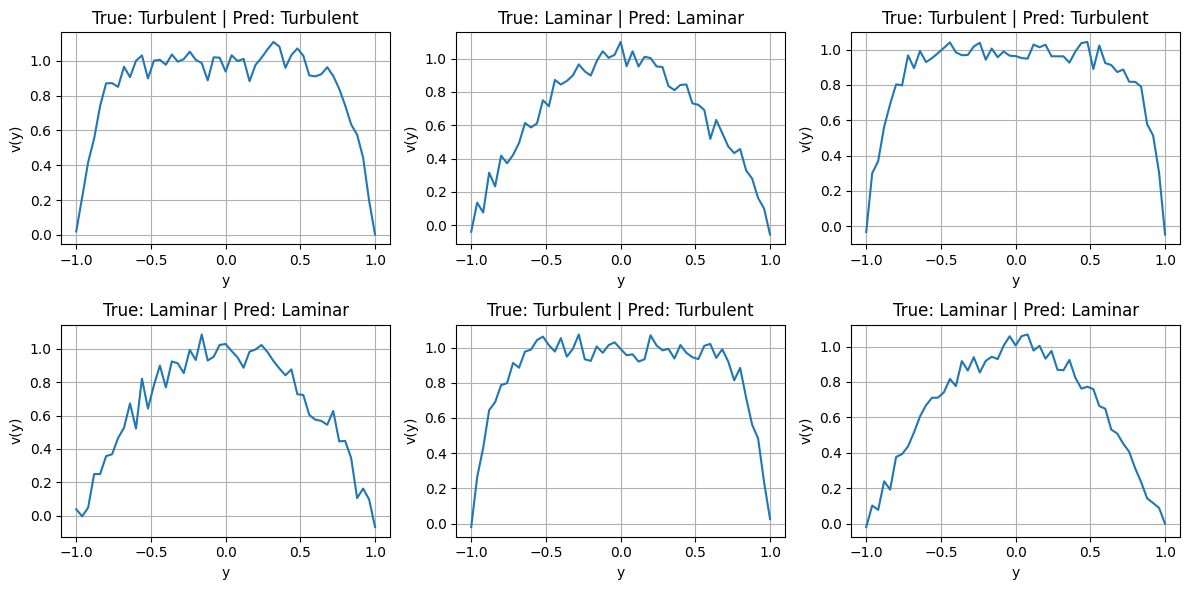

In [17]:
#@title Flow velocity profile classification using MLP

# --- Generate labeled dataset ---
n_samples_per_class = 200
n_points = 51
sigma = 0.05  # same noise level

X = []
y = []

for _ in range(n_samples_per_class):
    _, v_laminar = generate_velocity_profile('laminar', sigma=sigma)
    _, v_turbulent = generate_velocity_profile('turbulent', sigma=sigma)
    X.append(v_laminar)
    y.append(0)
    X.append(v_turbulent)
    y.append(1)

X = np.array(X)
y = np.array(y)

# --- Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Fit MLP classifier ---
mlp_clf = MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', max_iter=3000, random_state=42)
mlp_clf.fit(X_train, y_train)

# --- Evaluate ---
y_pred = mlp_clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"MLP Accuracy: {acc:.2f}")

# print("Confusion matrix:")
# print(confusion_matrix(y_test, y_pred))

# --- Visualize a few test samples ---
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
y_vals = np.linspace(-1, 1, n_points)

for i, ax in enumerate(axes.ravel()):
    idx = i
    ax.plot(y_vals, X_test[idx], label="Velocity profile")
    pred = mlp_clf.predict(X_test[idx].reshape(1, -1))[0]
    true = y_test[idx]
    ax.set_title(f"True: {'Laminar' if true == 0 else 'Turbulent'} | Pred: {'Laminar' if pred == 0 else 'Turbulent'}")
    ax.set_xlabel("y")
    ax.set_ylabel("v(y)")
    ax.grid(True)

plt.tight_layout()
plt.show()


Finally, MLP also achives 100% accuracy on the fluid flow example.

# Classification methods comparison

When looking at the velocity profiles classification shown throughout this notebook, we see that all of the methods achieved 100% accuracy. Often times, it is good to start with the simplest and most efficient method. If the results are not satisfactory for a given application, you should try out another method. Often times, some hyperparamter tinkering will be required before seeing better results. That is often the case with MLPs. Hence, give it some time when testing new methods as they tend to yield better results with some tuning.


Below, you can find decision boundaries derived using logistic regression, k-NN, SVM and MLP. Take a moment to look at the plots and draw conclusions on their classification capacity and overall quality of decision boundary.

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF F,G EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


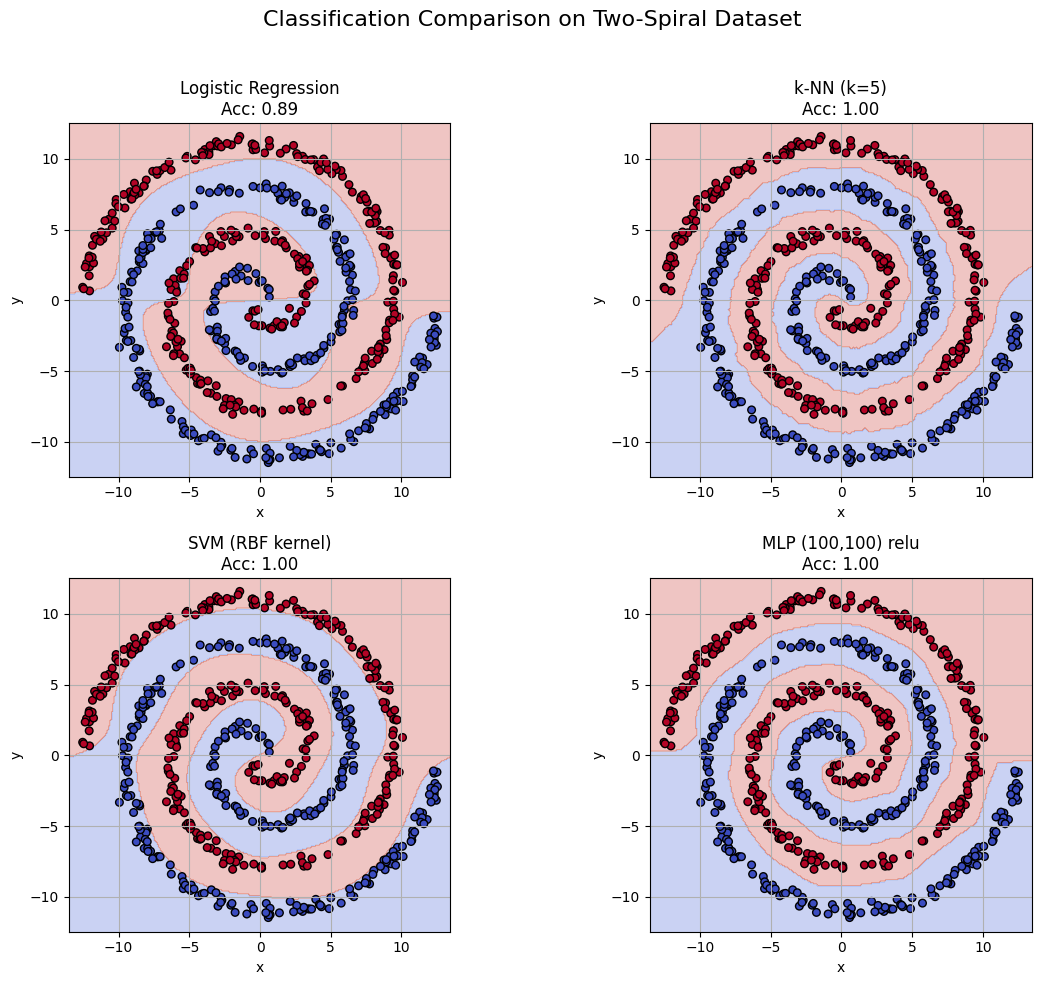

In [18]:
#@title Classification methods visualization with Accuracy

# --- Generate two spiral dataset ---
def generate_spiral(n_points, noise=0.2):
    theta = np.sqrt(np.random.rand(n_points)) * 4 * np.pi  # Angle
    r = theta
    x1 = r * np.cos(theta) + np.random.randn(n_points) * noise
    y1 = r * np.sin(theta) + np.random.randn(n_points) * noise

    x2 = -r * np.cos(theta) + np.random.randn(n_points) * noise
    y2 = -r * np.sin(theta) + np.random.randn(n_points) * noise

    X = np.vstack((np.column_stack((x1, y1)), np.column_stack((x2, y2))))
    y = np.array([0]*n_points + [1]*n_points)
    return X, y

# --- Generate dataset ---
np.random.seed(42)
X, y = generate_spiral(300, noise=0.25)

# --- Create mesh grid for plotting ---
h = 0.1
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
grid = np.c_[xx.ravel(), yy.ravel()]

# --- Logistic Regression with Polynomial Features ---
logreg = make_pipeline(PolynomialFeatures(degree=5), LogisticRegression(max_iter=15000))
logreg.fit(X, y)
Z_logreg = logreg.predict(grid).reshape(xx.shape)
acc_logreg = accuracy_score(y, logreg.predict(X))

# --- k-Nearest Neighbors ---
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X, y)
Z_knn = knn.predict(grid).reshape(xx.shape)
acc_knn = accuracy_score(y, knn.predict(X))

# --- Multi-Layer Perceptron ---
mlp = MLPClassifier(hidden_layer_sizes=(100, 100), activation='relu', max_iter=8000, random_state=42)
mlp.fit(X, y)
Z_mlp = mlp.predict(grid).reshape(xx.shape)
acc_mlp = accuracy_score(y, mlp.predict(X))

# --- SVM with RBF kernel ---
svm = SVC(kernel='rbf', gamma='scale', C=100000.0)
svm.fit(X, y)
Z_svm = svm.predict(grid).reshape(xx.shape)
acc_svm = accuracy_score(y, svm.predict(X))

# --- Plot all models ---
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Logistic Regression
axs[0, 0].contourf(xx, yy, Z_logreg, alpha=0.3, cmap=plt.cm.coolwarm)
axs[0, 0].scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolor='k', s=30)
axs[0, 0].set_title(f"Logistic Regression\nAcc: {acc_logreg:.2f}")
axs[0, 0].set_xlabel("x")
axs[0, 0].set_ylabel("y")
axs[0, 0].grid(True)
axs[0, 0].set_aspect('equal')

# k-NN
axs[0, 1].contourf(xx, yy, Z_knn, alpha=0.3, cmap=plt.cm.coolwarm)
axs[0, 1].scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolor='k', s=30)
axs[0, 1].set_title(f"k-NN (k=5)\nAcc: {acc_knn:.2f}")
axs[0, 1].set_xlabel("x")
axs[0, 1].set_ylabel("y")
axs[0, 1].grid(True)
axs[0, 1].set_aspect('equal')

# SVM
axs[1, 0].contourf(xx, yy, Z_svm, alpha=0.3, cmap=plt.cm.coolwarm)
axs[1, 0].scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolor='k', s=30)
axs[1, 0].set_title(f"SVM (RBF kernel)\nAcc: {acc_svm:.2f}")
axs[1, 0].set_xlabel("x")
axs[1, 0].set_ylabel("y")
axs[1, 0].grid(True)
axs[1, 0].set_aspect('equal')

# MLP
axs[1, 1].contourf(xx, yy, Z_mlp, alpha=0.3, cmap=plt.cm.coolwarm)
axs[1, 1].scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolor='k', s=30)
axs[1, 1].set_title(f"MLP (100,100) relu\nAcc: {acc_mlp:.2f}")
axs[1, 1].set_xlabel("x")
axs[1, 1].set_ylabel("y")
axs[1, 1].grid(True)
axs[1, 1].set_aspect('equal')

plt.suptitle("Classification Comparison on Two-Spiral Dataset", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


At first glance, we can see that logistic regression has the lowest accuracy score, which is reflected in a boundary that poorly fits the training data. This is due to the simplicity of this technique. It struggles when dealing with more complicated distributions. On the other hand, k-NN, SVM and MLP both achieve 100% accuracy. However, the two differ in the way that new points get classified. Now, if we wanted to sample a new point and check which class it belongs to, k-NN would need to check that point against every point in the data set in order to find the k nearest neighbors. On the other hand, SVM relies on a model derived from the data allowing for low computational overhead when classifying new data. Similarly,  MLP uses its network of weights to define the decision boundary. This approach makes it a lot easier and faster to classify data after the network is trained.